Для извлечения фичей будет использоваться библиотека librosa <br>*Установка
pip install librosa
или
conda install -c conda-forge librosa*

In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Рассмотрим конкректный пример из датасета

In [2]:
audio_data = 'wav_data/A30000A1.wav'
x , sr = librosa.load(audio_data, sr=None)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [3]:
print(x.shape, sr)

(24424,) 8000


Видим, что частота дискретизации = 8 кГц, как и было заявлено в задании.

**Воспроизведем аудио**

In [4]:
print('Audio Sampling Rate: '+str(sr)+' samples/sec')
print('Total Samples: '+str(np.size(x)))
secs=np.size(x)/sr
print('Audio Length: '+str(secs)+' s')
ipd.Audio(audio_data)

Audio Sampling Rate: 8000 samples/sec
Total Samples: 24424
Audio Length: 3.053 s


**Визуализация:**

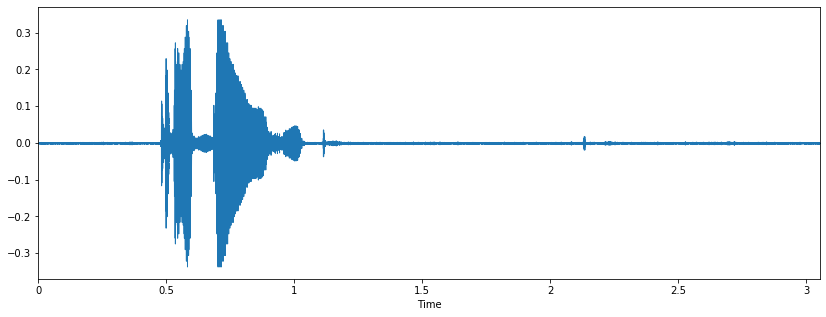

In [11]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr);

**Построим спектрограмму:**

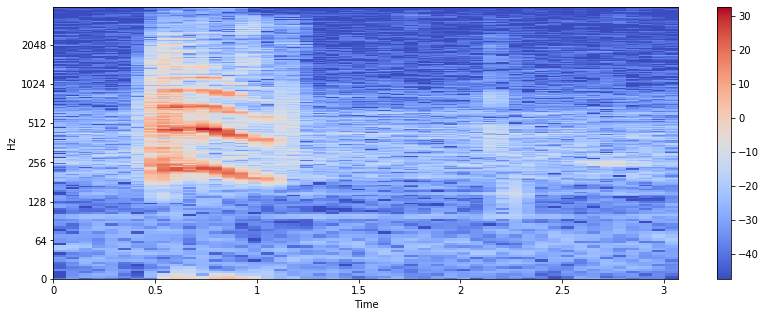

In [10]:
X = librosa.stft(x) #кратковременное преобразование Фурье
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar();

## 2. Извлечение фичей

### 2.1. Спектральный центроид
Указывает, на какой частоте сосредоточена энергия спектра или, другими словами, указывает, где расположен “центр масс” для звука.

In [7]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape

(48,)

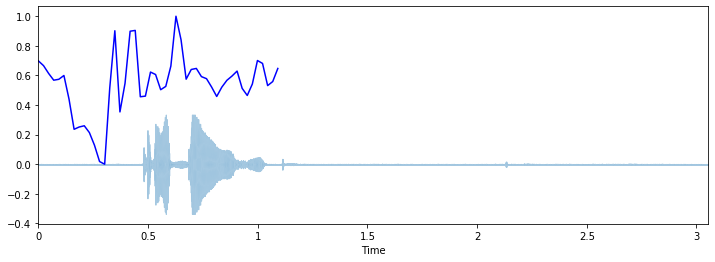

In [9]:
# Вычисление временной переменной для визуализации
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Нормализация спектрального центроида для визуализации
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
# Построение спектрального центроида вместе с формой волны
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b');

### 2.2. Спектральный спад
Это мера формы сигнала, представляющая собой частоту, в которой высокие частоты снижаются до 0. Чтобы получить ее, нужно рассчитать долю элементов в спектре мощности, где 85% ее мощности находится на более низких частотах.

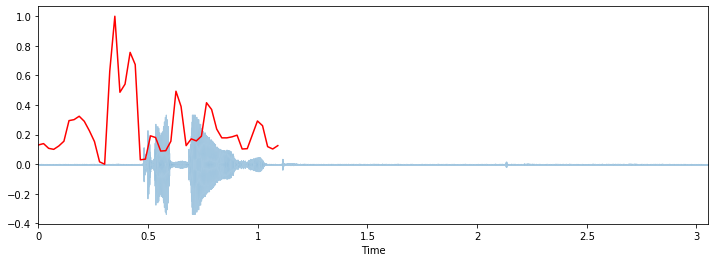

In [12]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r');

### 2.3. Спектральная ширина
Спектральная ширина определяется как ширина полосы света на половине максимальной точки

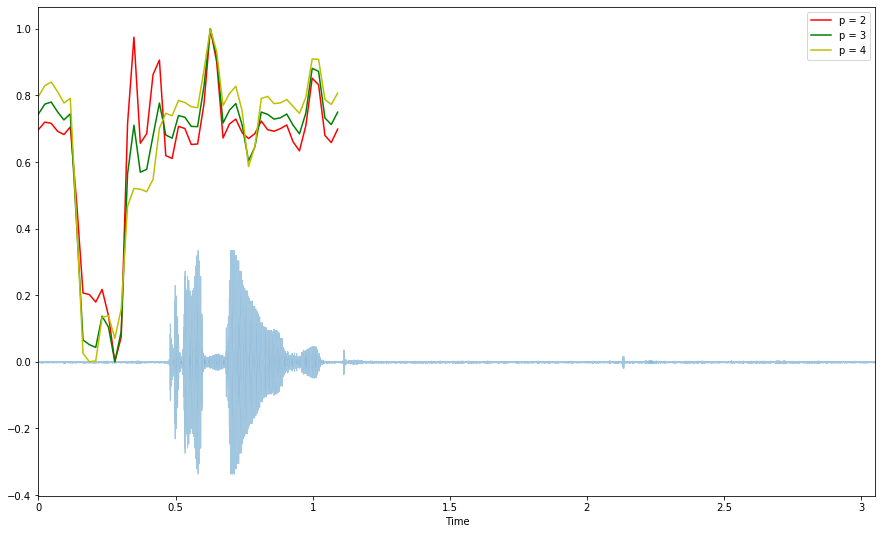

In [13]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'));

### 2.4. Скорость пересечения нуля
Простой способ измерения гладкости сигнала — вычисление числа пересечений нуля в пределах сегмента этого сигнала.

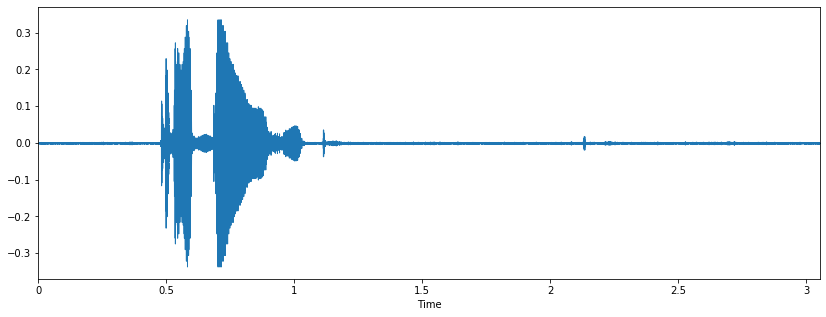

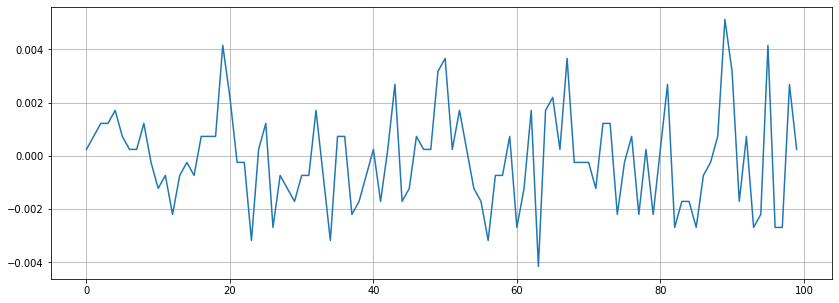

In [14]:
# Построение графика сигнала:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
# Увеличение масштаба:
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [15]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings)) # кол-во пересечений нуля

36


### 2.5. Мел-частотные кепстральные коэффициенты (MFCC)
Представляют собой небольшой набор признаков (обычно около 10–20), которые кратко описывают общую форму спектральной огибающей. Они моделируют характеристики человеческого голоса.

In [16]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

(20, 48)


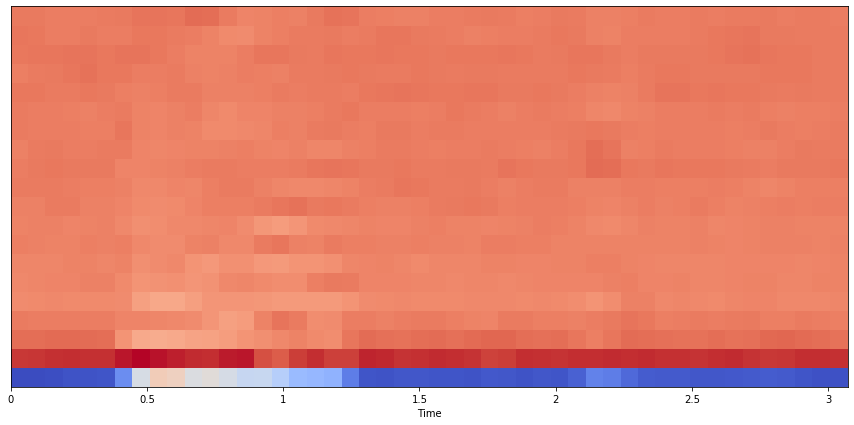

In [18]:
# Отображение MFCC:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time');

In [20]:
#mfccs

In [21]:
mfccs.shape

(20, 48)

In [22]:
import scipy
from scipy import stats

## 3. Cоздание фичей
### 3.1.Chroma
Цветность (chroma features) – это интересное и мощное представление для музыкального звука, при котором весь спектр проецируется на 12 контейнеров, представляющих 12 различных полутонов музыкальной октавы

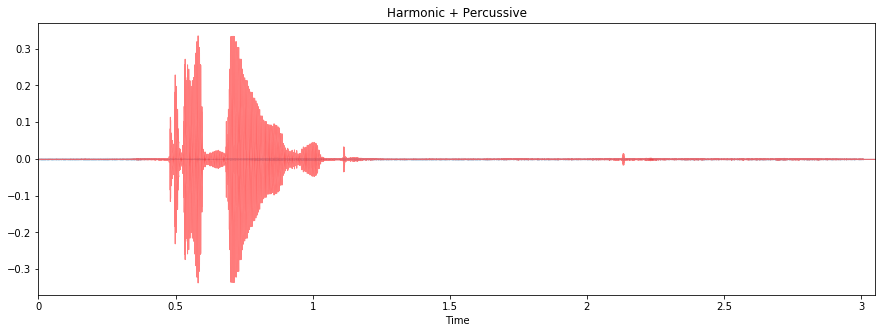

In [24]:
y_harmonic, y_percussive = librosa.effects.hpss(x)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y_harmonic, sr=sr, alpha=0.25)
librosa.display.waveplot(y_percussive, sr=sr, color='r', alpha=0.5)
plt.title('Harmonic + Percussive');

In [25]:
stft = np.abs(librosa.stft(x))
chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=8000).T,axis=0)
chroma

array([0.60136487, 0.59530248, 0.65249901, 0.6739962 , 0.59732602,
       0.59741488, 0.6222585 , 0.75566019, 0.87377404, 0.770461  ,
       0.72007956, 0.67045649])

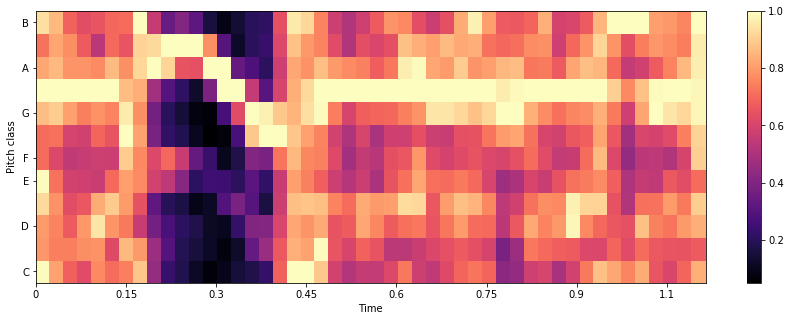

In [27]:
stft = np.abs(librosa.stft(x))
chroma=librosa.feature.chroma_stft(S=stft, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar();

In [28]:
chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sr))
chroma

0.6775494358446976

### 3.2. MFCCs

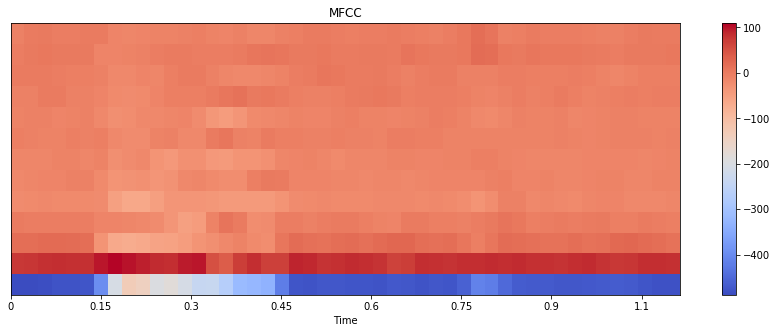

In [33]:
#mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=13)
mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)
plt.figure(figsize=(15, 5))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC');

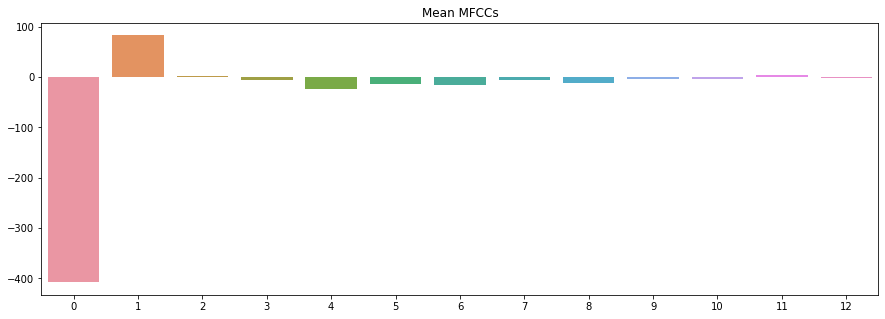

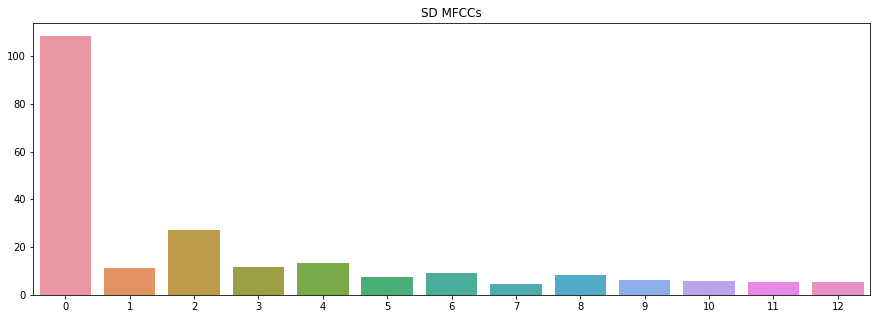

In [34]:
mfccs_mean=np.mean(mfccs,axis=1)
mfccs_std=np.std(mfccs,axis=1)

coeffs=np.arange(0,13)
plt.figure(figsize=(15,5))
plt.title('Mean MFCCs')
sns.barplot(x=coeffs, y=mfccs_mean)

plt.figure(figsize=(15,5))
plt.title('SD MFCCs')
sns.barplot(x=coeffs,y=mfccs_std);

In [35]:
#Generate the chroma Dataframe
mfccs_df=pd.DataFrame()
for i in range(0,13):
    mfccs_df['mfccs_mean_'+str(i)]=mfccs_mean[i]
for i in range(0,13):
    mfccs_df['mfccs_std_'+str(i)]=mfccs_mean[i]
mfccs_df.loc[0]=np.concatenate((mfccs_mean,mfccs_std),axis=0)
mfccs_df

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,...,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12
0,-407.934469,82.50941,1.813679,-5.727322,-23.445278,-13.102172,-15.378105,-6.764406,-12.140423,-3.209074,...,11.642213,13.342106,7.388883,9.334525,4.672516,8.398001,6.058317,5.763542,5.364306,5.51878


### 3.3.Spectral Features

#### 3.3.1 Spectral Centroid

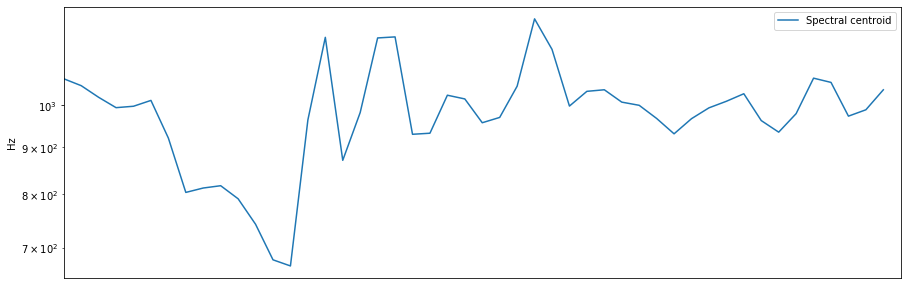

In [36]:
cent = librosa.feature.spectral_centroid(y=x, sr=sr)
plt.figure(figsize=(15,5))
plt.subplot(1, 1, 1)
plt.semilogy(cent.T, label='Spectral centroid')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, cent.shape[-1]])
plt.legend();

In [37]:
cent_mean=np.mean(cent)
cent_std=np.std(cent)
cent_skew=scipy.stats.skew(cent,axis=1)[0]
print('Mean: '+str(cent_mean))
print('SD: '+str(cent_std))
print('Skewness: '+str(cent_skew))

Mean: 979.6371348263368
SD: 118.12846482056206
Skewness: -0.5105135871525596


#### 3.3.2 Spectral Contrast

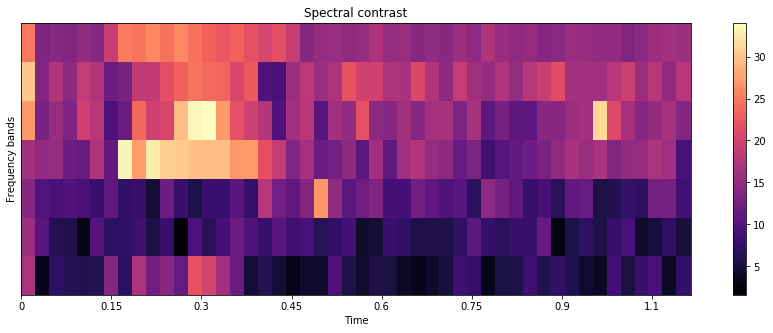

In [38]:
stft = np.abs(librosa.stft(x))
contrast=librosa.feature.spectral_contrast(S=stft, sr=sr, fmin=30)
plt.figure(figsize=(15,5))
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.ylabel('Frequency bands')
plt.title('Spectral contrast');

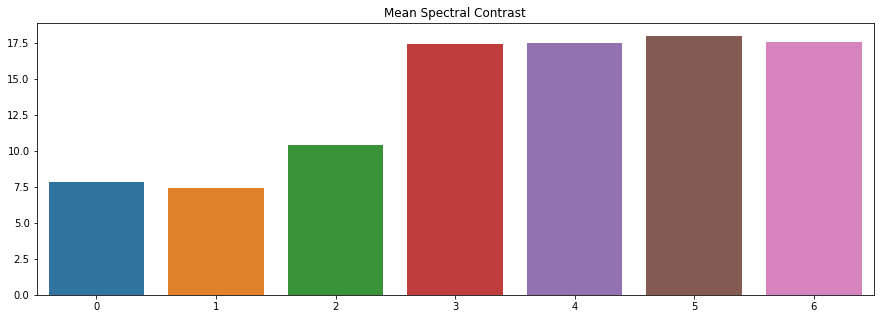

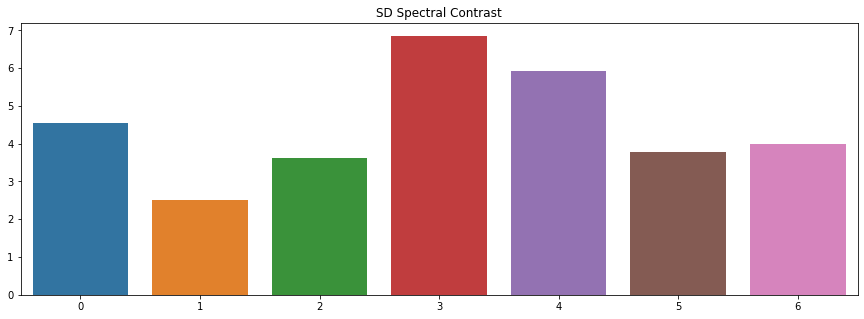

In [39]:
contrast_mean=np.mean(contrast,axis=1)
contrast_std=np.std(contrast,axis=1)

conts=np.arange(0,7)
plt.figure(figsize=(15,5))
plt.title('Mean Spectral Contrast')
sns.barplot(x=conts,y=contrast_mean)

plt.figure(figsize=(15,5))
plt.title('SD Spectral Contrast')
sns.barplot(x=conts,y=contrast_std)
#Generate the chroma Dataframe
contrast_df=pd.DataFrame()

In [41]:
#contrast_mean
#contrast_std

#### 3.3.2 Spectral Rolloff

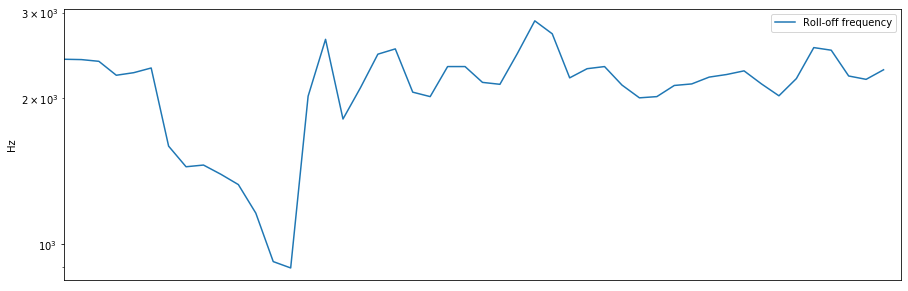

In [43]:
rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr)
plt.figure(figsize=(15,5))
plt.semilogy(rolloff.T, label='Roll-off frequency')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, rolloff.shape[-1]])
plt.legend();

In [44]:
rolloff_mean=np.mean(rolloff)
rolloff_std=np.std(rolloff)
rolloff_skew=scipy.stats.skew(rolloff,axis=1)[0]
print('Mean: '+str(rolloff_mean))
print('SD: '+str(rolloff_std))
print('Skewness: '+str(rolloff_skew))

Mean: 2102.6204427083335
SD: 429.1943041226292
Skewness: -1.1666726093069721


In [45]:
spectral_df=pd.DataFrame()
collist=['cent_mean','cent_std','cent_skew']
for i in range(0,7):
    collist.append('contrast_mean_'+str(i))
for i in range(0,7):
    collist.append('contrast_std_'+str(i))
collist=collist+['rolloff_mean','rolloff_std','rolloff_skew']
for c in collist:
    spectral_df[c]=0
data=np.concatenate(([cent_mean,cent_std,cent_skew],contrast_mean,contrast_std,[rolloff_mean,rolloff_std,rolloff_std]),axis=0)
spectral_df.loc[0]=data
spectral_df

,cent_mean,cent_std,cent_skew,contrast_mean_0,contrast_mean_1,contrast_mean_2,contrast_mean_3,contrast_mean_4,contrast_mean_5,contrast_mean_6,contrast_std_0,contrast_std_1,contrast_std_2,contrast_std_3,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew
0,979.637135,118.128465,-0.510514,7.861799,7.445682,10.400275,17.41791,17.486062,17.980494,17.537751,4.550107,2.508944,3.62976,6.851617,5.924077,3.7699,3.979338,2102.620443,429.194304,429.194304


### 3.4. Zero Crossing Rate

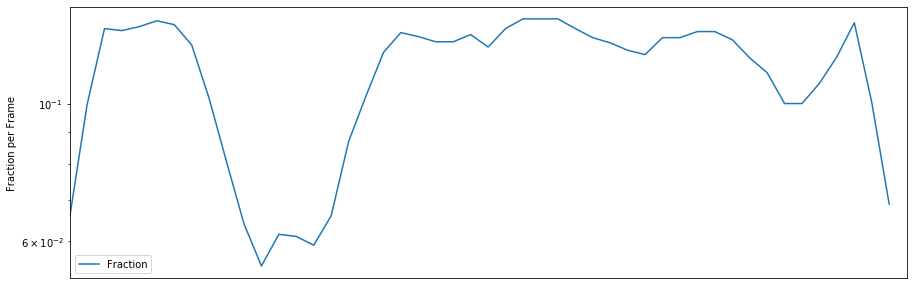

In [46]:
zrate=librosa.feature.zero_crossing_rate(y_harmonic)
plt.figure(figsize=(15,5))
plt.semilogy(zrate.T, label='Fraction')
plt.ylabel('Fraction per Frame')
plt.xticks([])
plt.xlim([0, rolloff.shape[-1]])
plt.legend();

In [47]:
zrate_mean=np.mean(zrate)
zrate_std=np.std(zrate)
zrate_skew=scipy.stats.skew(zrate,axis=1)[0]
print('Mean: '+str(zrate_mean))
print('SD: '+str(zrate_std))
print('Skewness: '+str(zrate_skew))

Mean: 0.111663818359375
SD: 0.025608624647675368
Skewness: -1.0221329588230272


In [48]:
zrate_df=pd.DataFrame()
zrate_df['zrate_mean']=0
zrate_df['zrate_std']=0
zrate_df['zrate_skew']=0
zrate_df.loc[0]=[zrate_mean,zrate_std,zrate_skew]
zrate_df

,zrate_mean,zrate_std,zrate_skew
0,0.111664,0.025609,-1.022133


### 3.5. Beat and Tempo

C:\Users\iziba_000\Anaconda3\lib\site-packages\librosa\filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
C:\Users\iziba_000\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Detected Tempo: 133.92857142857142 beats/min


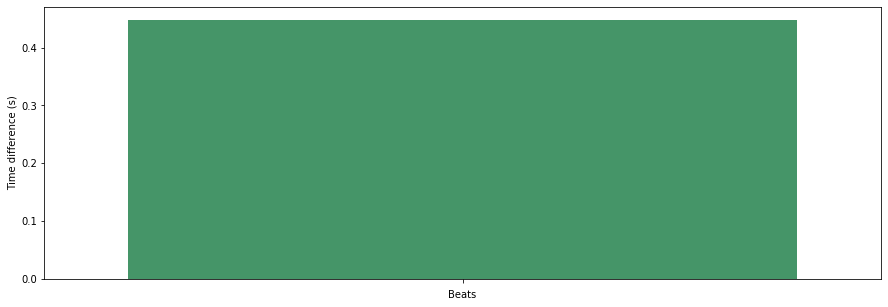

In [49]:
tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
print('Detected Tempo: '+str(tempo)+ ' beats/min')
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
beat_time_diff=np.ediff1d(beat_times)
beat_nums = np.arange(1, np.size(beat_times))

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
ax.set_ylabel("Time difference (s)")
ax.set_xlabel("Beats")
g=sns.barplot(beat_nums, beat_time_diff, palette="BuGn_d",ax=ax)
g=g.set(xticklabels=[]);

In [50]:
beat_df=pd.DataFrame()
beat_df['tempo']=tempo
beat_df.loc[0]=tempo
beat_df

,tempo
0,133.928571


## 4. Сформируем таблицу фичей по всем объектам

In [210]:
def features_for_one(x, sr):
    # извлечение фичей для одного объекта
    
    y_harmonic, y_percussive = librosa.effects.hpss(x)
    #chroma
    stft = np.abs(librosa.stft(x))
    chroma=librosa.feature.chroma_stft(S=stft, sr=sr)
    chroma_mean=np.mean(chroma,axis=1)
    chroma_std=np.std(chroma,axis=1)
    #Generate the chroma Dataframe
    chroma_df=pd.DataFrame()
    for i in range(0,12):
        chroma_df['chroma_mean_'+str(i)]=chroma_mean[i]
    for i in range(0,12):
        chroma_df['chroma_std_'+str(i)]=chroma_mean[i]
    chroma_df.loc[0]=np.concatenate((chroma_mean,chroma_std),axis=0)
    chroma_df

    #mfccs 
    mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=13)
    mfccs_mean=np.mean(mfccs,axis=1)
    mfccs_std=np.std(mfccs,axis=1)
    #Generate the chroma Dataframe
    mfccs_df=pd.DataFrame()
    for i in range(0,13):
        mfccs_df['mfccs_mean_'+str(i)]=mfccs_mean[i]
    for i in range(0,13):
        mfccs_df['mfccs_std_'+str(i)]=mfccs_mean[i]
    mfccs_df.loc[0]=np.concatenate((mfccs_mean,mfccs_std),axis=0)
    mfccs_df


    # Spectral Centroid
    cent = librosa.feature.spectral_centroid(y=x, sr=sr)
    cent_mean=np.mean(cent)
    cent_std=np.std(cent)
    cent_skew=scipy.stats.skew(cent,axis=1)[0]
#     print('Mean: '+str(cent_mean))
#     print('SD: '+str(cent_std))
#     print('Skewness: '+str(cent_skew))

    # Spectral Contrast
    stft = np.abs(librosa.stft(x))
    contrast=librosa.feature.spectral_contrast(S=stft, sr=sr, fmin=30)
    contrast_mean=np.mean(contrast,axis=1)
    contrast_std=np.std(contrast,axis=1)
    #Generate the chroma Dataframe
    contrast_df=pd.DataFrame()


    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr)
    rolloff_mean=np.mean(rolloff)
    rolloff_std=np.std(rolloff)
    rolloff_skew=scipy.stats.skew(rolloff,axis=1)[0]
#     print('Mean: '+str(rolloff_mean))
#     print('SD: '+str(rolloff_std))
#     print('Skewness: '+str(rolloff_skew))
    spectral_df=pd.DataFrame()
    collist=['cent_mean','cent_std','cent_skew']
    for i in range(0,7):
        collist.append('contrast_mean_'+str(i))
    for i in range(0,7):
        collist.append('contrast_std_'+str(i))
    collist=collist+['rolloff_mean','rolloff_std','rolloff_skew']
    for c in collist:
        spectral_df[c]=0
    data=np.concatenate(([cent_mean,cent_std,cent_skew],contrast_mean,contrast_std,[rolloff_mean,rolloff_std,rolloff_std]),axis=0)
    spectral_df.loc[0]=data
    spectral_df

    #Zero Crossing Rate
    zrate=librosa.feature.zero_crossing_rate(y_harmonic)
    zrate_mean=np.mean(zrate)
    zrate_std=np.std(zrate)
    zrate_skew=scipy.stats.skew(zrate,axis=1)[0]
#     print('Mean: '+str(zrate_mean))
#     print('SD: '+str(zrate_std))
#     print('Skewness: '+str(zrate_skew))

    zrate_df=pd.DataFrame()
    zrate_df['zrate_mean']=0
    zrate_df['zrate_std']=0
    zrate_df['zrate_skew']=0
    zrate_df.loc[0]=[zrate_mean,zrate_std,zrate_skew]
    zrate_df

    # Beat and Tempo
    tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
    #print('Detected Tempo: '+str(tempo)+ ' beats/min')
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    beat_time_diff=np.ediff1d(beat_times)
    beat_nums = np.arange(1, np.size(beat_times))
    beat_df=pd.DataFrame()
    beat_df['tempo']=tempo
    beat_df.loc[0]=tempo
    beat_df

    final_df=pd.concat((chroma_df,mfccs_df,spectral_df,zrate_df,beat_df),axis=1)
    return final_df


#### 4.1 Формируем таблицу по всем аудио файлам


In [62]:
directory = 'wav_data'
files = os.listdir(directory)

In [65]:
features_data = pd.DataFrame()
for file in files:
    if file[-3:] == 'wav':
            x0 , sr0 = librosa.load(str('wav_data/'+str(file)), sr=None)
            d0 =  features_for_one(x0, sr0)
            d0['file_name'] = file
            #print(d0)
            features_data = pd.concat((features_data, d0),  ignore_index=True)
    

C:\Users\iziba_000\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\iziba_000\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  in1zpadded[sc] = in1.copy()


In [66]:
features_data.head()

,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,...,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo,file_name
0,0.601365,0.595302,0.652499,0.673996,0.597326,0.597415,0.622258,0.755660,0.873774,0.770461,...,3.769900,3.979338,2102.620443,429.194304,429.194304,0.111664,0.025609,-1.022133,133.928571,A30000A1.wav
1,0.672984,0.695074,0.684668,0.708139,0.652890,0.603178,0.646920,0.756603,0.862593,0.809129,...,3.643072,3.511648,2242.519947,450.734845,450.734845,0.128761,0.033627,-0.596726,55.147059,A30000A2.wav
2,0.611095,0.605487,0.652722,0.685883,0.628059,0.597343,0.653260,0.751129,0.809235,0.831997,...,4.077986,3.789648,1990.853659,396.222857,396.222857,0.123714,0.028235,-1.120943,156.250000,A30000A3.wav
3,0.584046,0.614999,0.694067,0.680875,0.598400,0.620042,0.661662,0.800759,0.910555,0.718492,...,4.450606,3.244809,2212.284483,347.346269,347.346269,0.131491,0.025108,-1.506767,156.250000,A30000A4.wav
4,0.706563,0.662098,0.676899,0.712251,0.634589,0.616169,0.666259,0.801162,0.910538,0.760339,...,3.681433,4.391513,2223.245873,387.426763,387.426763,0.127386,0.034153,-1.519281,234.375000,A30000A5.wav


In [67]:
#features_data.info()

### 4.2. Подгрузим лэйблы из файлов f.txt и m.txt

In [71]:
males_list = []
with open("m.txt", "r") as tx2:
    for line in tx2:
        line = line.strip()
        males_list.append(line)
        
females_list = []
with open("f.txt", "r") as tx2:
    for line in tx2:
        line = line.strip()
        females_list.append(line)

In [72]:
print(len(males_list))
print(len(females_list))

102
103


In [74]:
features_data.loc[0, 'gender']
features_data.loc[0]

chroma_mean_0        0.601365
chroma_mean_1        0.595302
chroma_mean_2        0.652499
chroma_mean_3        0.673996
chroma_mean_4        0.597326
                     ...     
zrate_std           0.0256086
zrate_skew           -1.02213
tempo                 133.929
file_name        A30000A1.wav
gender                    NaN
Name: 0, Length: 76, dtype: object

In [76]:
for f in females_list:
    if f in features_data['file_name'].values:
        idx = features_data[features_data['file_name'] == f].index[0] #индекс элемента
        features_data.loc[idx, 'gender'] = 0 #женщины

for m in males_list:
    if m in features_data['file_name'].values:
        idx = features_data[features_data['file_name'] == m].index[0] #индекс элемента
        features_data.loc[idx, 'gender'] = 1 #мужчины

In [77]:
features_data.head()

,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,...,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo,file_name,gender
0,0.601365,0.595302,0.652499,0.673996,0.597326,0.597415,0.622258,0.755660,0.873774,0.770461,...,3.979338,2102.620443,429.194304,429.194304,0.111664,0.025609,-1.022133,133.928571,A30000A1.wav,0
1,0.672984,0.695074,0.684668,0.708139,0.652890,0.603178,0.646920,0.756603,0.862593,0.809129,...,3.511648,2242.519947,450.734845,450.734845,0.128761,0.033627,-0.596726,55.147059,A30000A2.wav,0
2,0.611095,0.605487,0.652722,0.685883,0.628059,0.597343,0.653260,0.751129,0.809235,0.831997,...,3.789648,1990.853659,396.222857,396.222857,0.123714,0.028235,-1.120943,156.250000,A30000A3.wav,0
3,0.584046,0.614999,0.694067,0.680875,0.598400,0.620042,0.661662,0.800759,0.910555,0.718492,...,3.244809,2212.284483,347.346269,347.346269,0.131491,0.025108,-1.506767,156.250000,A30000A4.wav,0
4,0.706563,0.662098,0.676899,0.712251,0.634589,0.616169,0.666259,0.801162,0.910538,0.760339,...,4.391513,2223.245873,387.426763,387.426763,0.127386,0.034153,-1.519281,234.375000,A30000A5.wav,0


In [78]:
features_data.to_csv('features_data.csv')

**Проверим нет ли звуковых дорожек с одинаковым наименованием**

In [79]:
features_data.shape[0]-len(features_data['file_name'].unique())

0

Ответ: Нет, все наименования дорожек различны. <br><br>**Проверим все ли звуковые дорожки размечены**

In [80]:
features_data['gender'].unique()

array([0, 1], dtype=int64)

Ответ: все, т.к. нет пустых значений

### 5 Препроцессинг
#### 5.1. Посмотрим на основную статистику

In [81]:
features_data.describe()

,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,...,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo,gender
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,...,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.00000
mean,0.678494,0.676511,0.711606,0.710506,0.686472,0.694420,0.729264,0.772811,0.809311,0.777585,...,3.782828,3.622927,2523.336417,428.091512,428.091512,0.148102,0.053978,0.063786,145.152836,0.50000
std,0.070658,0.082896,0.093555,0.079740,0.093047,0.099260,0.093264,0.084333,0.069438,0.064613,...,0.813050,0.879080,332.149837,108.569345,108.569345,0.043698,0.026016,0.794445,77.707001,0.50123
min,0.521042,0.459805,0.449265,0.464970,0.435717,0.434229,0.451659,0.524056,0.631555,0.620308,...,2.136779,1.971536,1797.577563,169.849949,169.849949,0.045376,0.020048,-1.735390,36.057692,0.00000
25%,0.637457,0.626429,0.654400,0.661571,0.617001,0.629034,0.682411,0.737277,0.774470,0.735761,...,3.212843,2.913504,2277.270260,349.526913,349.526913,0.121617,0.033178,-0.378128,93.750000,0.00000
50%,0.675748,0.670717,0.710366,0.720193,0.699202,0.699931,0.740335,0.786140,0.818579,0.778198,...,3.687114,3.507614,2563.971158,439.257503,439.257503,0.140418,0.046506,0.225434,117.187500,0.50000
75%,0.717559,0.714794,0.785805,0.770221,0.764820,0.768433,0.794422,0.835428,0.859896,0.826216,...,4.266399,4.394409,2789.134166,504.218510,504.218510,0.177302,0.072165,0.624459,187.500000,1.00000
max,0.859880,0.886953,0.889667,0.846447,0.872558,0.897733,0.886256,0.925336,0.942135,0.929116,...,6.028571,5.584638,3176.192434,735.159795,735.159795,0.328375,0.150389,2.465570,312.500000,1.00000


#### 5.2 Выясним, **сбалансированны ли** представленые классы

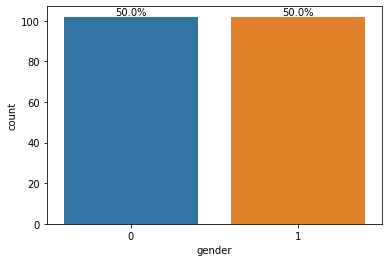

In [82]:
lab = features_data['gender']
dist = lab.value_counts()
ax = sns.countplot(lab)
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/len(lab)), (x.mean(), y), 
            ha='center', va='bottom') 

Видим, что **классы сбалансированы** и в процедуре сэмплинга не нуждаются.

#### 5.3. Проверим, есть ли пропущенные значения

In [212]:
features_data.isnull().sum().unique()

array([0], dtype=int64)

**Пропущенных значений нет** , иначе пришлось бы заполнять пропуски.

#### 5.4.  Корреляция Пирсона

Для удобства представления сгруппируем параметры

In [84]:
features_data.columns

Index(['chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11',
       'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
       'mfccs_std_11', 'mfccs_std_12', 'cent_mean', 'cent_std', 'cent_skew',
       'contrast_mean_0', 'contrast_mean_1', 'contrast_mean_2'

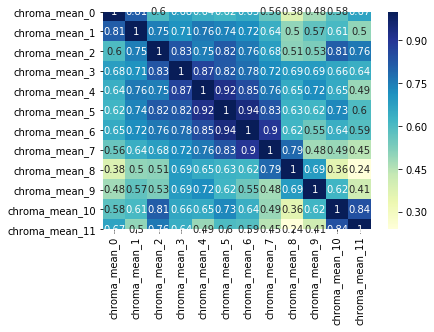

In [85]:
df_corr = features_data.drop(columns = [  'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11', 'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
       'mfccs_std_11', 'mfccs_std_12', 'cent_mean', 'cent_std', 'cent_skew',
       'contrast_mean_0', 'contrast_mean_1', 'contrast_mean_2',
       'contrast_mean_3', 'contrast_mean_4', 'contrast_mean_5',
       'contrast_mean_6', 'contrast_std_0', 'contrast_std_1', 'contrast_std_2',
       'contrast_std_3', 'contrast_std_4', 'contrast_std_5', 'contrast_std_6',
       'rolloff_mean', 'rolloff_std', 'rolloff_skew', 'zrate_mean',
       'zrate_std', 'zrate_skew', 'tempo', 'file_name', 'gender'])
corr_matrix = df_corr.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True, cmap="YlGnBu")

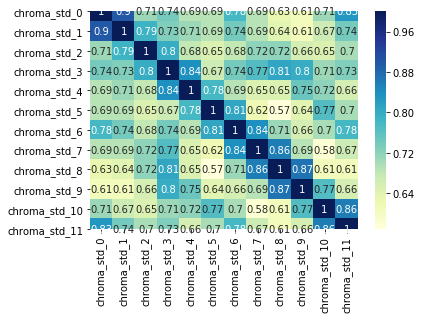

In [86]:
df_corr2 = features_data.drop(columns = [ 'chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
       'mfccs_std_11', 'mfccs_std_12', 'cent_mean', 'cent_std', 'cent_skew',
       'contrast_mean_0', 'contrast_mean_1', 'contrast_mean_2',
       'contrast_mean_3', 'contrast_mean_4', 'contrast_mean_5',
       'contrast_mean_6', 'contrast_std_0', 'contrast_std_1', 'contrast_std_2',
       'contrast_std_3', 'contrast_std_4', 'contrast_std_5', 'contrast_std_6',
       'rolloff_mean', 'rolloff_std', 'rolloff_skew', 'zrate_mean',
       'zrate_std', 'zrate_skew', 'tempo', 'file_name', 'gender'])
corr_matrix2 = df_corr2.corr().round(2)
sns.heatmap(data=corr_matrix2, annot=True, cmap="YlGnBu")

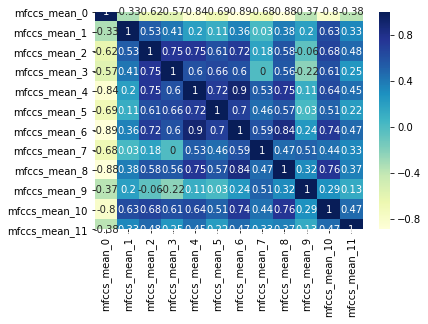

In [87]:
df_corr2 = features_data.drop(columns = ['chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11',      
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
       'mfccs_std_11', 'mfccs_std_12', 'cent_mean', 'cent_std', 'cent_skew',
       'contrast_mean_0', 'contrast_mean_1', 'contrast_mean_2',
       'contrast_mean_3', 'contrast_mean_4', 'contrast_mean_5',
       'contrast_mean_6', 'contrast_std_0', 'contrast_std_1', 'contrast_std_2',
       'contrast_std_3', 'contrast_std_4', 'contrast_std_5', 'contrast_std_6',
       'rolloff_mean', 'rolloff_std', 'rolloff_skew', 'zrate_mean',
       'zrate_std', 'zrate_skew', 'tempo', 'file_name', 'gender'])
corr_matrix2 = df_corr2.corr().round(2)
sns.heatmap(data=corr_matrix2, annot=True, cmap="YlGnBu")

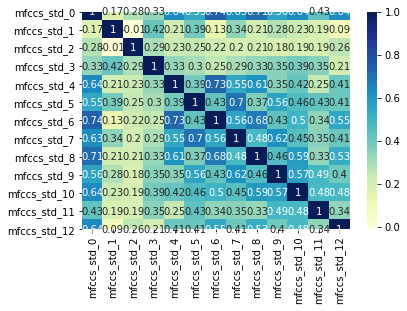

In [88]:
df_corr2 = features_data.drop(columns = ['chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11',
       'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12',  'cent_mean', 'cent_std', 'cent_skew',
       'contrast_mean_0', 'contrast_mean_1', 'contrast_mean_2',
       'contrast_mean_3', 'contrast_mean_4', 'contrast_mean_5',
       'contrast_mean_6', 'contrast_std_0', 'contrast_std_1', 'contrast_std_2',
       'contrast_std_3', 'contrast_std_4', 'contrast_std_5', 'contrast_std_6',
       'rolloff_mean', 'rolloff_std', 'rolloff_skew', 'zrate_mean',
       'zrate_std', 'zrate_skew', 'tempo', 'file_name', 'gender'])
corr_matrix2 = df_corr2.corr().round(2)
sns.heatmap(data=corr_matrix2, annot=True, cmap="YlGnBu")

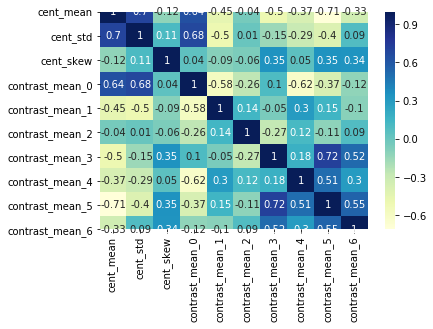

In [89]:
df_corr2 = features_data.drop(columns = ['chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11',
       'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
       'mfccs_std_11', 'mfccs_std_12', 'contrast_std_0', 'contrast_std_1', 'contrast_std_2',
       'contrast_std_3', 'contrast_std_4', 'contrast_std_5', 'contrast_std_6',
       'rolloff_mean', 'rolloff_std', 'rolloff_skew', 'zrate_mean',
       'zrate_std', 'zrate_skew', 'tempo', 'file_name', 'gender'])
corr_matrix2 = df_corr2.corr().round(2)
sns.heatmap(data=corr_matrix2, annot=True, cmap="YlGnBu")

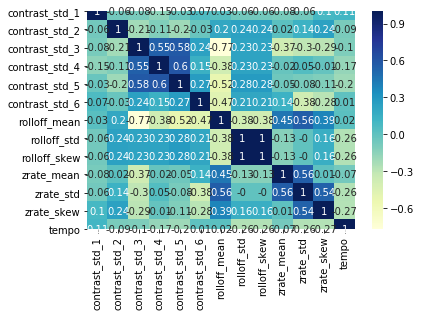

In [90]:
df_corr2 = features_data.drop(columns = ['chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11',
       'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
       'mfccs_std_11', 'mfccs_std_12', 'cent_mean', 'cent_std', 'cent_skew',
       'contrast_mean_0', 'contrast_mean_1', 'contrast_mean_2',
       'contrast_mean_3', 'contrast_mean_4', 'contrast_mean_5',
       'contrast_mean_6', 'contrast_std_0',  'file_name', 'gender'])
corr_matrix2 = df_corr2.corr().round(2)
sns.heatmap(data=corr_matrix2, annot=True, cmap="YlGnBu")

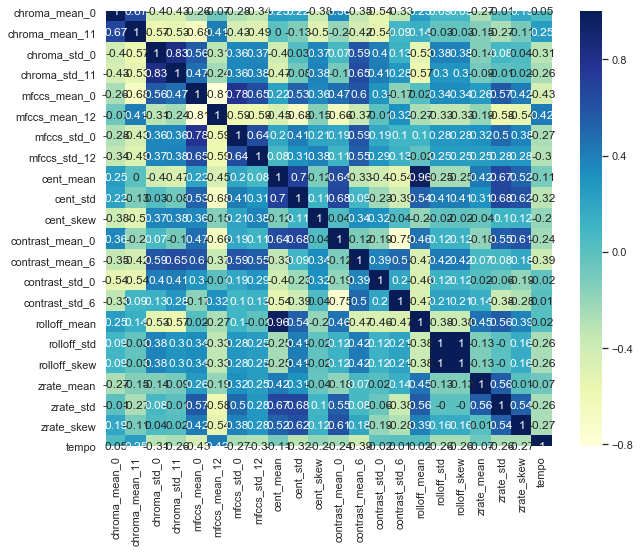

In [91]:
sns.set(rc={'figure.figsize':(10,8)})
df_corr2 = features_data.drop(columns = [ 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 
        'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 
        'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
        'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
       'mfccs_std_11', 'contrast_mean_1', 'contrast_mean_2',
       'contrast_mean_3', 'contrast_mean_4', 'contrast_mean_5',
       'contrast_std_1', 'contrast_std_2',
       'contrast_std_3', 'contrast_std_4', 'contrast_std_5', 'file_name', 'gender'])
corr_matrix2 = df_corr2.corr().round(2)
sns.heatmap(data=corr_matrix2, annot=True, cmap="YlGnBu")

Видим, что имеются параметры с большими значениями взаимной корреляции.

#### 5.5. Построим кросс-плоты
Для каждого из параметра построим кросс-плот, разделяя при этом выборки по полу (фиолетовый - мужчины, желтый - женщины, бронзовый - пересечений кросс-плотов). Будем отмечать для себя признаки, который свойственны одному из полов, но не свойственны другому.

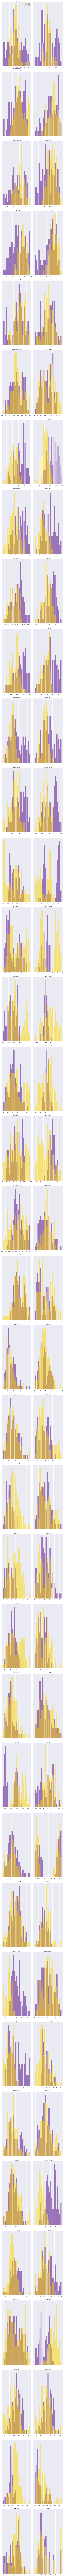

In [92]:
#Plot the histograms
male = features_data.loc[features_data['gender']==0]
female = features_data.loc[features_data['gender']==1]
fig, axes = plt.subplots(37, 2, figsize=(10,400))
ax = axes.ravel()
for i in range(74):
    ax[i].hist(male.iloc[:,i], bins=20, color='indigo', alpha=.5)
    ax[i].hist(female.iloc[:, i], bins=20, color='gold', alpha=.5)
    ax[i].set_title(list(male)[i])
    ax[i].set_yticks(())
    
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["male", "female"], loc="best")
fig.tight_layout()

## 6. Построение моделей

### 6.1. Сформируем обучающую и тестовую выборки

In [93]:
X = features_data.drop(columns = [ 'file_name', 'gender'])
y = features_data['gender']

In [94]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [96]:
svm = SVC()
svc_pip = Pipeline([
        ("scaler",MinMaxScaler()),
        ('svc', svm),
    ])

In [97]:
svc_pip.fit(X_train, y_train)

C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [98]:
y_predict = svc_pip.predict(X_test)

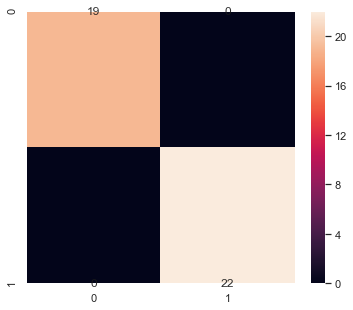

In [100]:
plt.figure(figsize=(6,5))
annot_kws={'fontsize':12,              
           'color':"k",
           'alpha':0.9, 
          'verticalalignment':'center'
           }
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm,  annot=True, annot_kws=annot_kws)

In [102]:
accuracy_score(y_test, y_predict)

1.0

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

### 6.2. Logistic Regeression

In [104]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [105]:
print("Logistic Regression Test Accuracy = {}".format(lr.score(X_test, y_test)))

Logistic Regression Test Accuracy = 1.0


In [106]:
cv_lin = cross_validate(lr, X, y, cv=5, scoring=('accuracy', 'roc_auc'),return_train_score=True)

C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iter

In [107]:
cv_lin['test_accuracy']

array([1.        , 0.95238095, 0.975     , 0.875     , 0.925     ])

### 6.3. SGD

In [108]:
sgd = SGDClassifier(loss = 'modified_huber', shuffle = True)
sgd.fit(X_train, y_train)

print("Accuracy score of SGD : {}".format(sgd.score(X_test, y_test)))

C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Accuracy score of SGD : 0.8048780487804879


In [144]:
param_grid_sgd = {"loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"]}
grid_sgd = GridSearchCV(sgd, param_grid_sgd, n_jobs=-1, cv=5)
grid_sgd.fit(X_train, y_train)

C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['hinge', 'log', 'squared_hinge', 'modified_huber'], 'alpha': [0.0001, 0.001, 0.01, 0.1], 'penalty': ['l2', 'l1', 'elasticnet', 'none']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [145]:
grid_sgd.best_score_ , grid_sgd.best_params_

(0.7484662576687117, {'alpha': 0.0001, 'loss': 'log', 'penalty': 'none'})

In [146]:
sgd_best = SGDClassifier(alpha=0.0001, loss='log', penalty='none')
res_sgd_best = cross_validate(sgd_best, X, y, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True)

C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default 

In [147]:
res_sgd_best['test_accuracy']

array([0.83333333, 0.5       , 0.575     , 0.6       , 0.575     ])

In [148]:
res_sgd_best['test_accuracy'].mean()

0.6166666666666666

### 6.4. KNN

In [109]:
knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(X_train, y_train)

print ("Accuracy score of KNN : {}".format(knn.score(X_test, y_test)))

Accuracy score of KNN : 0.926829268292683


In [123]:
param_grid_knn = {"n_neighbors": [3,5,7,9,13,19], "weights": ["uniform", "distance"], 
                  "p" : [1, 2]}
grid_knn = GridSearchCV(knn, param_grid_knn, n_jobs=-1, cv=5)
grid_knn.fit(X_train, y_train)

C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 13, 19], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [124]:
grid_knn.best_score_ , grid_knn.best_params_

(0.9447852760736196, {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'})

In [138]:
knn_best = KNeighborsClassifier(n_neighbors=3, p=1, weights='uniform')
res_knn_best = cross_validate(knn_best, X, y, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True)

In [139]:
res_knn_best['test_accuracy']

array([0.9047619, 0.9047619, 0.975    , 0.95     , 0.9      ])

In [140]:
res_knn_best['test_accuracy'].mean()

0.9269047619047619

### 6.5. Decision tree model

In [141]:
tree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
print("Decision Tree")
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Decision Tree
Accuracy on training set: 1.000
Accuracy on test set: 0.976


In [142]:
res_tree = cross_validate(tree, X, y, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True)
res_tree['test_accuracy']

array([0.95238095, 0.88095238, 0.875     , 0.925     , 0.875     ])

In [143]:
res_tree['test_accuracy'].mean()

0.9016666666666666

In [129]:
param_grid_tree = {'criterion':['gini','entropy'], 'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90],
                  'min_samples_split':[2,4,6], 'min_samples_leaf':[1,3,5]}
grid_tree = GridSearchCV(tree, param_grid_tree, n_jobs=-1, cv=5)
grid_tree.fit(X_train, y_train)

C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [130]:
grid_tree.best_score_ , grid_tree.best_params_

(0.9141104294478528,
 {'criterion': 'gini',
  'max_depth': 4,
  'min_samples_leaf': 1,
  'min_samples_split': 6})

In [135]:
tree_best = DecisionTreeClassifier(criterion='gini',  max_depth=4, min_samples_split=6)
res_tree_best = cross_validate(tree_best, X, y, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True)

In [136]:
res_tree_best['test_accuracy']

array([0.92857143, 0.85714286, 0.9       , 0.9       , 0.95      ])

In [137]:
res_tree_best['test_accuracy'].mean()

0.9071428571428571

### 6.6. Random forest model

In [196]:
forest = RandomForestClassifier(n_estimators=5, random_state=0).fit(X_train, y_train)
print("Random Forests")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Random Forests
Accuracy on training set: 0.988
Accuracy on test set: 0.976


In [197]:
param_grid_rfc = {"n_estimators": [10,20,30,50,100,150], "max_features": ["auto", "sqrt", "log2"], 
                  "min_samples_split" : [2,4,8],    "bootstrap": [True, False],  'max_depth':[5,12,25,30,100], 
                  'max_features':[3,5,6]}
grid_forest = GridSearchCV(forest, param_grid_rfc, n_jobs=-1, cv=5)
grid_forest.fit(X_train, y_train)

C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 50, 100, 150], 'max_features': [3, 5, 6], 'min_samples_split': [2, 4, 8], 'bootstrap': [True, False], 'max_depth': [5, 12, 25, 30, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [198]:
grid_forest.best_score_ , grid_forest.best_params_

(0.9938650306748467,
 {'bootstrap': False,
  'max_depth': 5,
  'max_features': 5,
  'min_samples_split': 4,
  'n_estimators': 50})

In [218]:
forest_best = RandomForestClassifier(bootstrap=False, max_depth=5, max_features=5, min_samples_split=4, n_estimators=50, random_state=10)
res_forest_best = cross_validate(forest_best, X, y, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True)

In [219]:
res_forest_best['test_accuracy']

array([1.  , 1.  , 1.  , 1.  , 0.95])

### 6.7. Gradient boosting model

In [116]:
gbrt = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
print("Gradient Boosting")
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Gradient Boosting
Accuracy on training set: 1.000
Accuracy on test set: 0.976


In [168]:
# param_grid_gbrt = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.05, 0.075, 0.1, 0.2],
#     "min_samples_split": [2,4,6],
#     "min_samples_leaf": [1,3,7],
#     "max_depth":[3,5,8]
#     }
param_grid_gbrt = {
    "loss":["deviance", "exponential"],
    "learning_rate": [0.05,  0.1, 0.2],
    "min_samples_split": [2,4,6],
    "min_samples_leaf": [1,3,7]   
    }
grid_gbrt = GridSearchCV(gbrt, param_grid_gbrt, n_jobs=-1, cv=5)
grid_gbrt.fit(X_train, y_train)

C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.05, 0.1, 0.2], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 3, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [169]:
grid_gbrt.best_score_ , grid_gbrt.best_params_

(0.9754601226993865,
 {'learning_rate': 0.2,
  'loss': 'deviance',
  'min_samples_leaf': 7,
  'min_samples_split': 2})

In [179]:
gbrt_best = GradientBoostingClassifier(learning_rate=0.2, loss='deviance', min_samples_leaf=7, min_samples_split=2)
res_gbrt_best = cross_validate(gbrt_best, X, y, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True)

In [180]:
res_gbrt_best['test_accuracy']

array([0.95238095, 1.        , 0.975     , 0.95      , 0.925     ])

In [181]:
res_gbrt_best['test_accuracy'].mean()

0.9604761904761905

### 6.8. Support vector machine model

In [152]:
svm = SVC().fit(X_train, y_train)
print("Support Vector Machine")
print("Accuracy on training set: {:.3f}".format(svm.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(svm.score(X_test, y_test)))

C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Support Vector Machine
Accuracy on training set: 1.000
Accuracy on test set: 0.463


In [153]:
param_grid_svm = { 'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1, 3, 7, 10]    }
grid_svm = GridSearchCV(svm, param_grid_svm, n_jobs=-1, cv=5)
grid_svm.fit(X_train, y_train)

C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'C': [1, 3, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [154]:
grid_svm.best_score_ , grid_svm.best_params_

(0.9693251533742331, {'C': 1, 'kernel': 'linear'})

In [161]:
svm_best = SVC(C=1, kernel='linear')
res_svm_best = cross_validate(svm_best, X, y, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True)

In [162]:
res_svm_best['test_accuracy']

array([1.        , 0.97619048, 0.975     , 0.975     , 0.975     ])

In [163]:
res_svm_best['test_accuracy'].mean()

0.9802380952380952

### 6.9. MLP

In [164]:
mlp = MLPClassifier(random_state=0).fit(X_train, y_train)
print("Multilayer Perceptron")
print("Accuracy on training set: {:.3f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test, y_test)))

Multilayer Perceptron
Accuracy on training set: 0.969
Accuracy on test set: 1.000


C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [165]:
mlp_best = MLPClassifier(random_state=0)
res_mlp_best = cross_validate(mlp_best, X, y, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True)

C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\iziba_000\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.ma

In [166]:
res_mlp_best['test_accuracy']

array([1.   , 1.   , 0.925, 0.825, 0.9  ])

In [167]:
res_mlp_best['test_accuracy'].mean()

0.93

### 6.10. Fully Connected NN
Tensorflow and Keras

In [20]:
import pandas as pd
import numpy as np

In [56]:
state = np.random.get_state()
np.random.seed(42)

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Nadam
from keras.utils.np_utils import to_categorical

In [3]:
df = pd.read_csv('features_data.csv')

In [6]:
df = df.drop(columns = ['Unnamed: 0'])
df.head()

,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,...,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo,file_name,gender
0,0.601365,0.595302,0.652499,0.673996,0.597326,0.597415,0.622258,0.755660,0.873774,0.770461,...,3.979338,2102.620443,429.194304,429.194304,0.111664,0.025609,-1.022133,133.928571,A30000A1.wav,0
1,0.672984,0.695074,0.684668,0.708139,0.652890,0.603178,0.646920,0.756603,0.862593,0.809129,...,3.511648,2242.519947,450.734845,450.734845,0.128761,0.033627,-0.596726,55.147059,A30000A2.wav,0
2,0.611095,0.605487,0.652722,0.685883,0.628059,0.597343,0.653260,0.751129,0.809235,0.831997,...,3.789648,1990.853659,396.222857,396.222857,0.123714,0.028235,-1.120943,156.250000,A30000A3.wav,0
3,0.584046,0.614999,0.694067,0.680875,0.598400,0.620042,0.661662,0.800759,0.910555,0.718492,...,3.244809,2212.284483,347.346269,347.346269,0.131491,0.025108,-1.506767,156.250000,A30000A4.wav,0
4,0.706563,0.662098,0.676899,0.712251,0.634589,0.616169,0.666259,0.801162,0.910538,0.760339,...,4.391513,2223.245873,387.426763,387.426763,0.127386,0.034153,-1.519281,234.375000,A30000A5.wav,0


In [100]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = [ 'file_name', 'gender'])
y = df['gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [101]:
X = df.drop(columns = [ 'file_name', 'gender'], axis=1)
y = df.gender

y = to_categorical(y, 2)
x_input = Input(shape=(74,))

In [102]:
model = Sequential() 

model.add(Dense(74, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics=['accuracy'])

In [103]:
kFold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
epochs = 150
batch_size = 10

scores = []
for train, test in kFold.split(X, y[:, 0]):
    model.fit(X.values[train], y[train], 
              validation_data=(X.values[test], y[test]), 
              epochs=epochs, batch_size=batch_size, verbose=0)
    score = model.evaluate(X.values[test], y[test], verbose=0)
    print('Accuracy: {:.3f}'.format(score[1]))
    scores.append(score[1])
print('Neural network: {:.3f}±{:.3f}'.format(np.mean(scores), np.std(scores)))
np.random.set_state(state)

Accuracy: 0.981
Accuracy: 1.000
Accuracy: 0.980
Accuracy: 1.000
Neural network: 0.990±0.010


In [104]:
scores

[0.9807692170143127, 1.0, 0.9800000190734863, 1.0]

# 7. Сравнение результатов

Сравним **accuracy**, которая получалась на кросс валидации каждой модели

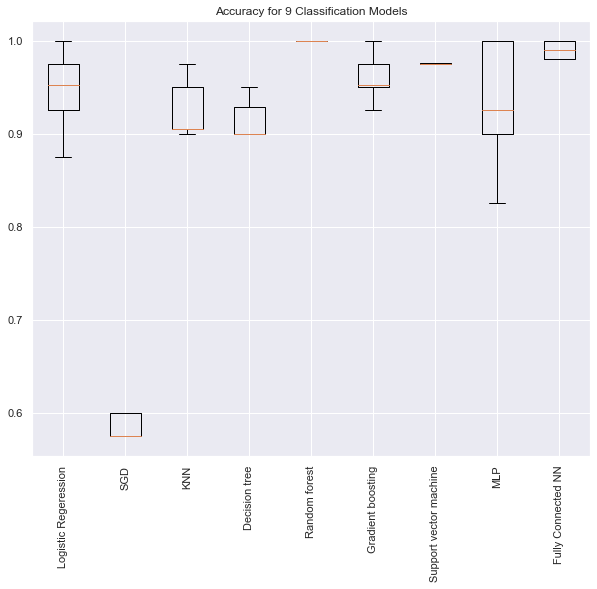

In [205]:
res_fcnn = np.array([0.98, 1.0, 0.98, 1.0]) # получили ниже
data = [cv_lin['test_accuracy'], res_sgd_best['test_accuracy'], res_knn_best['test_accuracy'],
        res_tree_best['test_accuracy'], res_forest_best['test_accuracy'], res_gbrt_best['test_accuracy'], 
        res_svm_best['test_accuracy'], res_mlp_best['test_accuracy'], res_fcnn]
fig3, ax3 = plt.subplots()
ax3.set_title('Accuracy for 9 Classification Models')
ax3.boxplot(data, showfliers=False, 
            labels=['Logistic Regeression', 'SGD', 'KNN', 'Decision tree', 'Random forest',
                    'Gradient boosting', 'Support vector machine', 'MLP',  'Fully Connected NN'])
plt.xticks(rotation = 90);
plt.show()

## Выясним, какие переменные наиболее значимы

In [206]:
def plot_feature_importances_mydata(model, features_data=features_data):
    plt.figure(figsize=(10,25))
    n_features = X_train.shape[1]
    plt.barh(range(n_features), forest.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), list(features_data))
    plt.xlabel("Variable importance")
    plt.ylabel("Independent Variable")

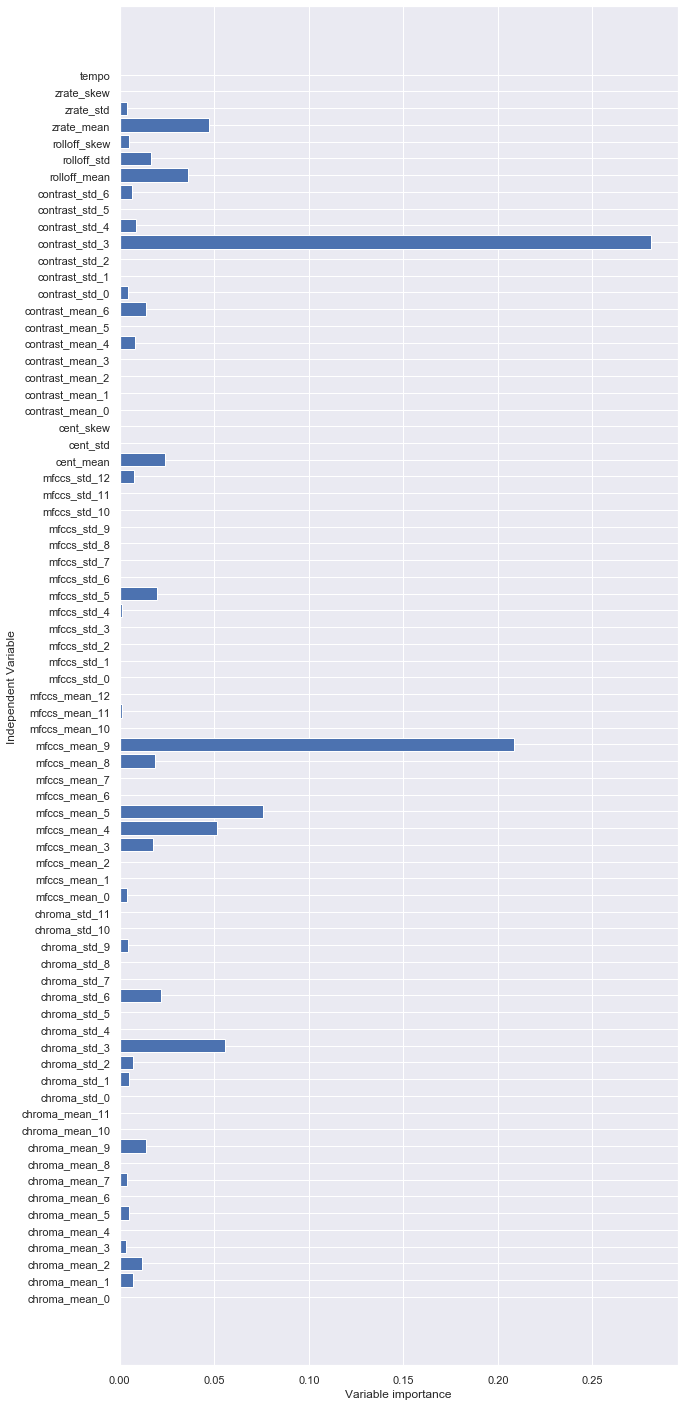

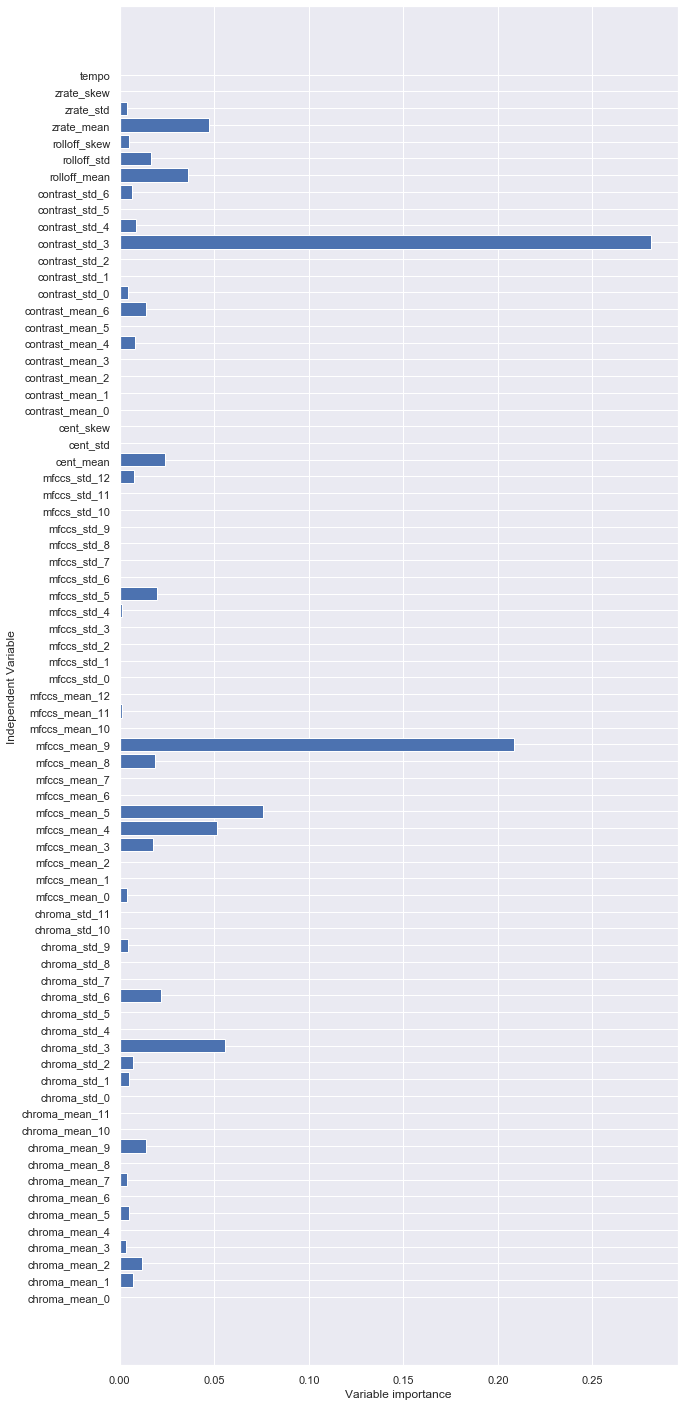

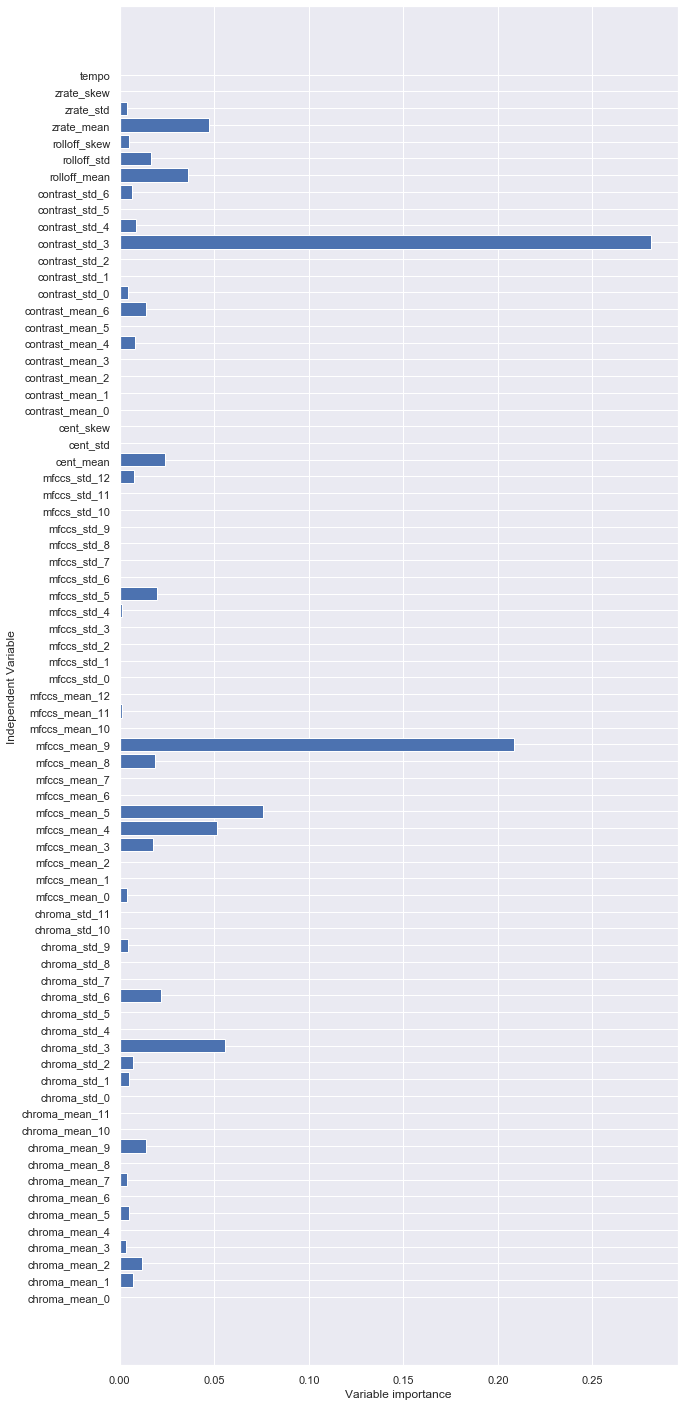

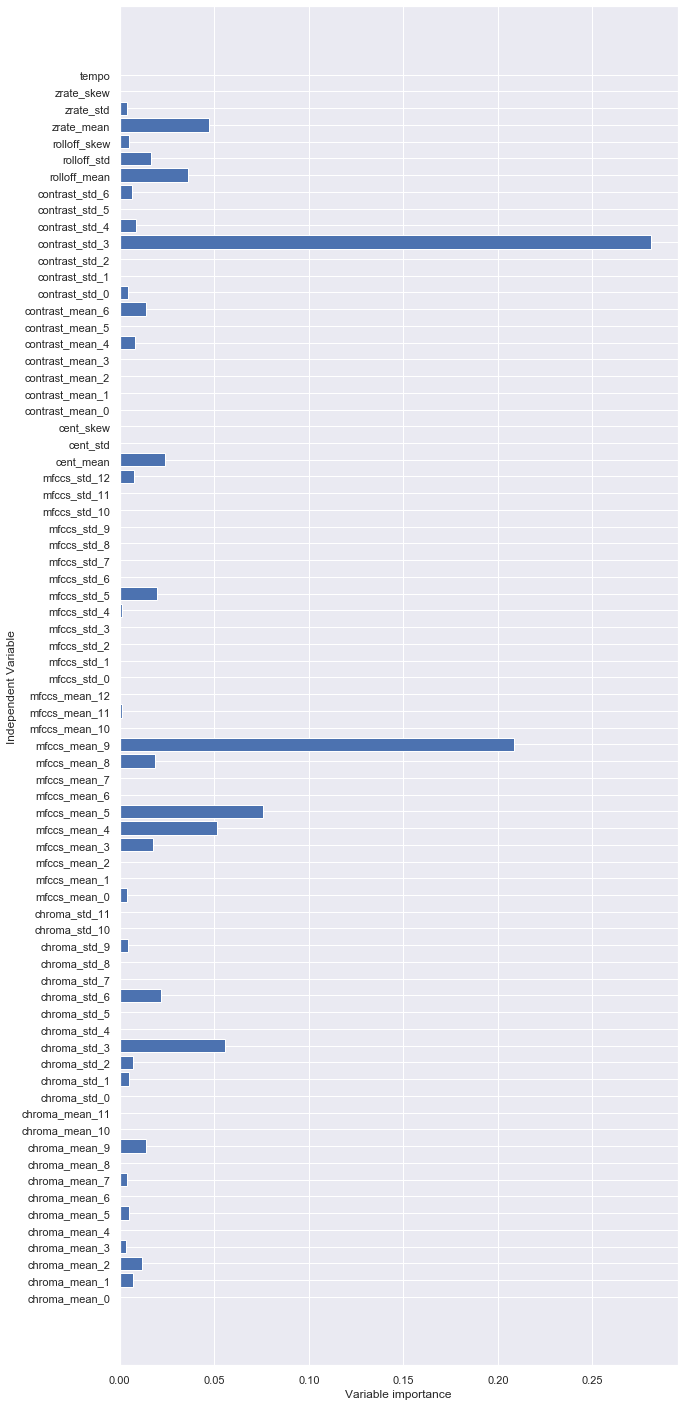

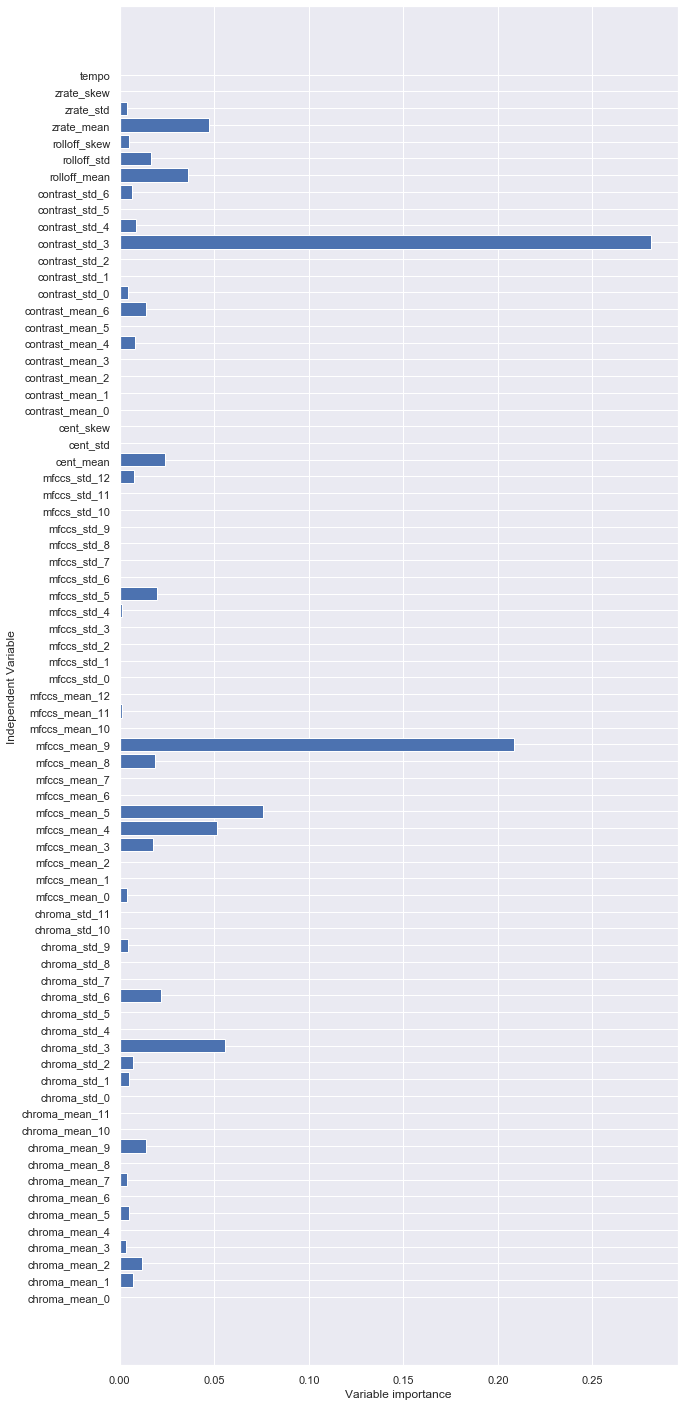

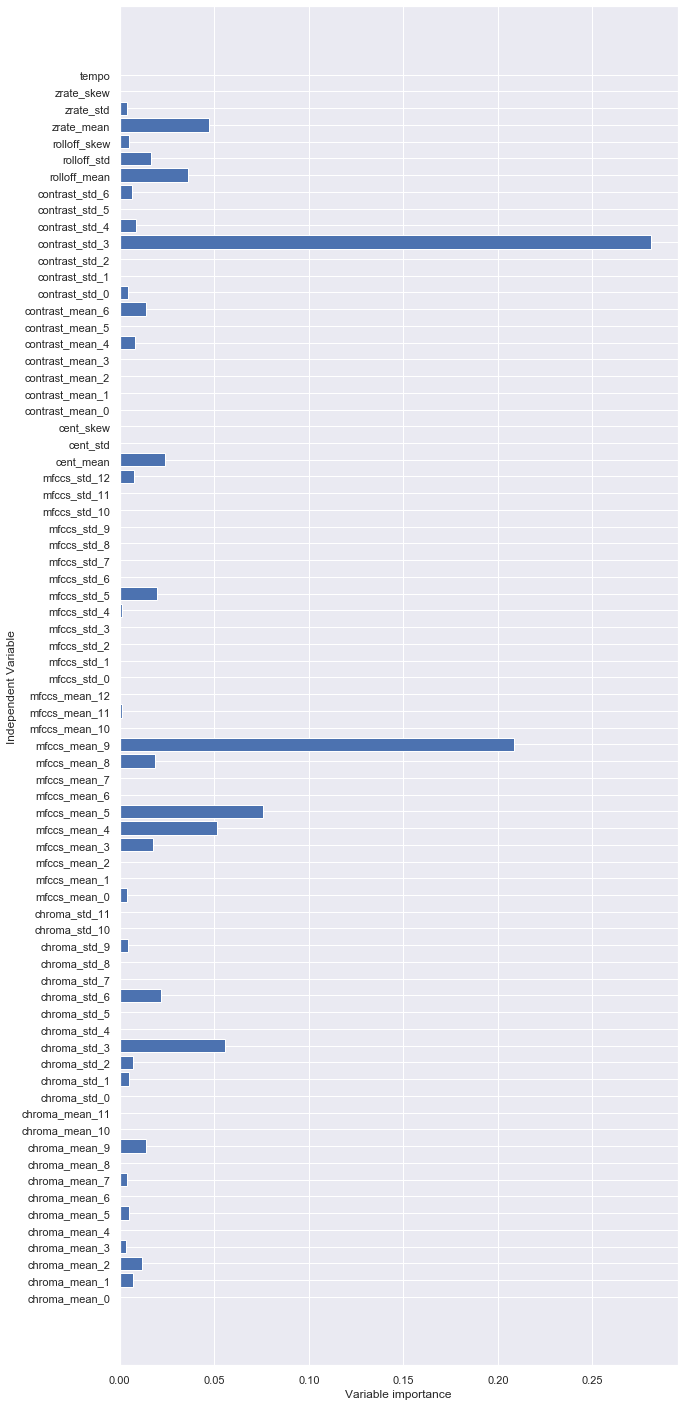

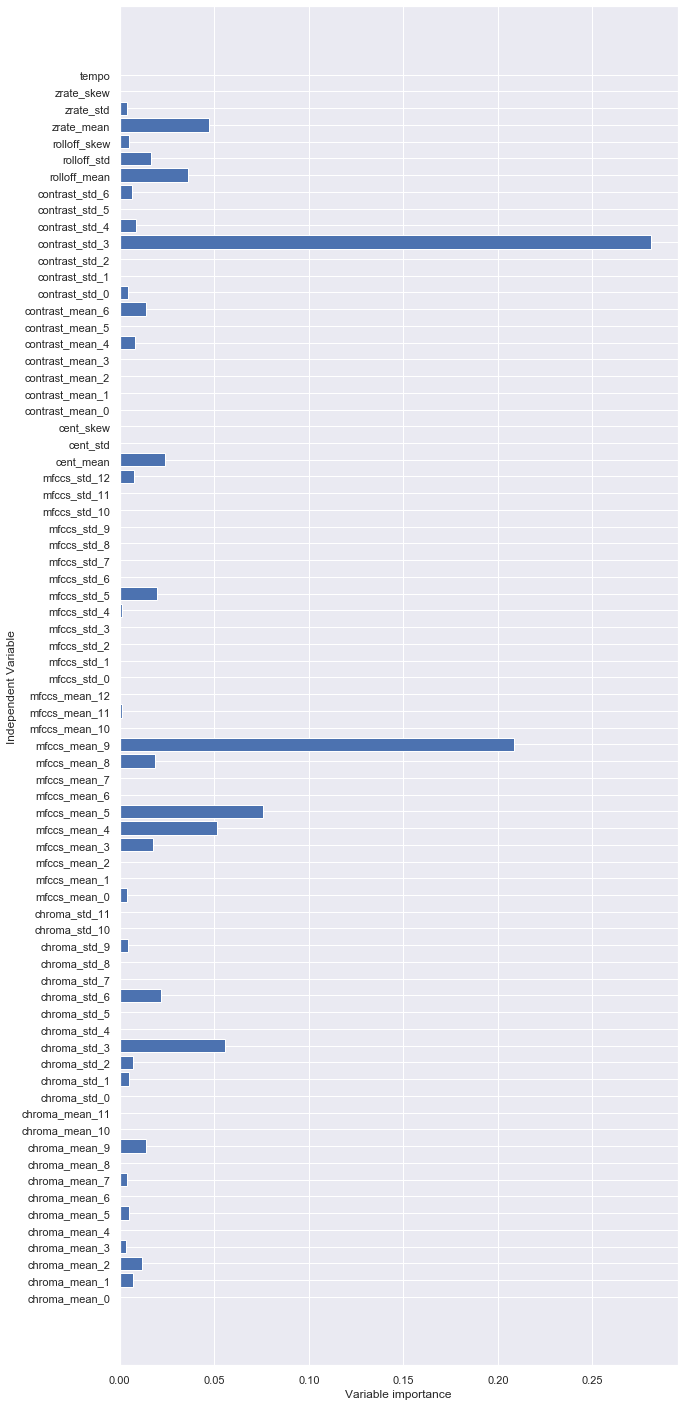

In [207]:
models = ['lr', 'sgd_bes', 'knn_best', 'tree_best', 'forest_best', 'gbrt_best', 'svm_best']
for mod in models:
    plot_feature_importances_mydata(mod)

## Вывод №1:
- У исследований, направленных на классификацию звуковых сигналов **есть большие перспективы**;
- В рамках данного исследования **наилучшие результаты показала модель Random Fores**t. Однако, стоит заметить, что все модели показали достойные результаты (кроме SGD). Для того, чтобы определить какая модель будет наилучшей в полевых условиях необходимо провести дополнительные исследования (см.пункт "Дальнейшие планы");
- Наиболее значимыми параметрами во всех моделях оказались параметры: **contrast_std_3, mfccs_mean_9** (это видно и из кросс-плотов в п.5.5.) .


 ## Дальнейшие планы
 Для обеспечения высокого качества работы моделей машинного обучения будет нелишним:
 - увеличить  размер обучающей выборки;
 - сделать выборку разнообразнее (н-р, добавив шумы);
 - провести обучение моделей при других random_state и сравнить средние результаты;
 - выбрать другую метрику качества (н-р, roc_auc);
 - подобрать другие features, которые окажутся более значимыми;
 - перевести звуковые сигналы в спектрограммы и поработать со свёрточными нейронными сетями.

## Тест модели (Random Forest) на своих примерах
###  Пример 1 (Мужской голос)

In [223]:
forest_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=5, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [260]:
def test_full(address, model=forest_best):
    #модель должна быть обученной
    audio_data01 = address
    x01 , sr01 = librosa.load(audio_data01, sr=None)
    print('Audio Sampling Rate: '+str(sr01)+' samples/sec')
    print('Total Samples: '+str(np.size(x01)))
    secs01=np.size(x01)/sr01
    print('Audio Length: '+str(secs01)+' s')
    ipd.Audio(audio_data01)
    
    features_test01 = features_for_one(x01, sr01)
    ans = ['Мужчина' if model.predict(features_test01.values)[0]==1 else 'Женщина']
    return ans[0]

In [261]:
ipd.Audio('politic.wav')

In [262]:
test_full('politic.wav')

Audio Sampling Rate: 16000 samples/sec
Total Samples: 57600
Audio Length: 3.6 s


C:\Users\iziba_000\Anaconda3\lib\site-packages\librosa\filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
C:\Users\iziba_000\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


'Мужчина'

#### Ответ правильный

###  Пример 2 (Женский голос)

Модель **правильно** определяет женские голоса из данного датасета:

In [263]:
ipd.Audio('wav_data\A30002S5.wav')

In [264]:
test_full('wav_data\A30002S5.wav')

Audio Sampling Rate: 8000 samples/sec
Total Samples: 35319
Audio Length: 4.414875 s


C:\Users\iziba_000\Anaconda3\lib\site-packages\librosa\filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
C:\Users\iziba_000\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


'Женщина'

Модель **неправильно** определяет женские голоса из сторонних источников

In [278]:
ipd.Audio('computer_disk.wav')

In [279]:
test_full('computer_disk.wav')

Audio Sampling Rate: 22050 samples/sec
Total Samples: 31684
Audio Length: 1.4369160997732426 s


C:\Users\iziba_000\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\iziba_000\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\iziba_000\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an ar

'Мужчина'

In [280]:
ipd.Audio('computer_access.wav')

In [281]:
test_full('computer_access.wav')

Audio Sampling Rate: 22050 samples/sec
Total Samples: 33088
Audio Length: 1.5005895691609978 s


C:\Users\iziba_000\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


'Мужчина'

### Вывод №2:
Возможно, модель неправильно классифицирует женские голоса из-за того, что частотные спектры русского и английского языка могут отличаться. Модель обучалась на голосах русскоязычных людей. В любом случае необходимы дополнительные исследования и доработка существующей модели (см. пункт "Дальнейшие планы").